<a href="https://colab.research.google.com/github/leonfrench/polyprotein_stats/blob/main/notebooks/process_human_prottrans_t5_xl_u50_model_embeddings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#This workbook processes the embeddings from the h5 file provided by Christian Dallago and Burkhard Rost.
#it converts them to csv, adds gene symbols and creates a umap version and puts that on google drive 

In [2]:
!wget https://zenodo.org/record/5047020/files/reduced_embeddings_file.h5?download=1 --output-document reduced_embeddings_file.h5


--2022-02-10 18:29:34--  https://zenodo.org/record/5047020/files/reduced_embeddings_file.h5?download=1
Resolving zenodo.org (zenodo.org)... 137.138.76.77
Connecting to zenodo.org (zenodo.org)|137.138.76.77|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 92008224 (88M) [application/octet-stream]
Saving to: ‘reduced_embeddings_file.h5’

reduced_embeddings_ 100%[===================>]  87.75M  11.9MB/s    in 7.7s    

2022-02-10 18:29:43 (11.4 MB/s) - ‘reduced_embeddings_file.h5’ saved [92008224/92008224]



In [3]:
!pip install umap-learn

     |████████████████████████████████| 86 kB 2.6 MB/s 
     |████████████████████████████████| 1.1 MB 35.6 MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.2-py3-none-any.whl size=82708 sha256=4e7643c9022a034631374960fc1d8b296b7753c15f1069e4700711defaae0172
  Stored in directory: /root/.cache/pip/wheels/84/1b/c6/aaf68a748122632967cef4dffef68224eb16798b6793257d82
  Created wheel for pynndescent: filename=pynndescent-0.5.6-py3-none-any.whl size=53943 sha256=4d19a83ffe60c2ac99af7dbf8e4629be3d32f5dfdbd6b86a01ed737dc14e33fd
  Stored in directory: /root/.cache/pip/wheels/03/f1/56/f80d72741e400345b5a5b50ec3d929aca581bf45e0225d5c50
Successfully built umap-learn pynndescent


In [4]:
import pandas as pd
import numpy as np
from google.colab import drive
import io
import os
import matplotlib.pyplot as plt
import h5py
import umap
from sklearn.preprocessing import StandardScaler

In [5]:
#code from bio-embeddings example notebook
proteins = []
with h5py.File('reduced_embeddings_file.h5', 'r') as f:
    for new_identifier in f.keys():
        proteins.append((new_identifier, f[new_identifier].attrs["original_id"], np.array(f[new_identifier])))

In [6]:
z = pd.DataFrame(proteins)
proteins_df = pd.DataFrame(z[2].tolist())
proteins_df['ids'] = z[1]

In [7]:
cols = proteins_df.columns.tolist()
cols = cols[-1:] + cols[:-1]
proteins_df = proteins_df[cols]
proteins_df

,ids,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,...,984,985,986,987,988,989,990,991,992,993,994,995,996,997,998,999,1000,1001,1002,1003,1004,1005,1006,1007,1008,1009,1010,1011,1012,1013,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
0,sp|Q8WZ42|TITIN_HUMAN,0.270260,0.094025,-0.095503,-0.048253,0.000436,0.082057,-0.240062,0.128832,-0.053393,0.041404,-0.088806,0.171922,-0.040681,-0.093189,-0.093623,-0.104046,-0.248815,0.093446,-0.012549,-0.080026,-0.108780,0.030576,0.268121,-0.069864,0.055001,-0.050724,-0.037338,-0.162795,0.013283,0.065105,-0.017070,-0.270321,-0.078319,0.078225,-0.094986,-0.016305,-0.018201,0.090028,0.016845,...,0.018356,0.091618,0.038833,0.084805,-0.088788,0.017509,0.046620,-0.198831,-0.065909,0.001917,0.038033,0.071409,0.037244,0.008557,0.048663,-0.037325,0.076659,-0.158532,0.064191,0.262681,0.091597,0.006721,-0.183095,0.139297,0.044190,0.210944,0.001196,-0.174974,-0.034107,0.005113,-0.060774,0.046698,0.155342,-0.030418,0.081636,-0.000785,-0.030125,-0.183085,0.058204,0.175141
1,sp|Q8WXI7|MUC16_HUMAN,0.107915,-0.132914,0.143527,0.133724,0.123092,-0.024516,-0.155162,-0.042184,0.085139,-0.026809,-0.031080,0.147404,0.059284,-0.022256,-0.106076,-0.169554,-0.146496,-0.060187,0.133892,-0.010323,-0.001729,0.006569,0.303102,0.042812,0.115541,0.108920,-0.105567,-0.176419,-0.202073,-0.095490,-0.084077,0.004576,-0.111460,-0.027670,-0.103118,0.079257,-0.032728,0.115251,-0.101931,...,0.051518,-0.017296,-0.075918,0.072068,-0.092838,-0.122486,0.058244,-0.060126,-0.005022,0.168510,0.032314,-0.111120,-0.043505,-0.071895,0.037595,-0.095448,-0.016122,0.024011,0.045072,-0.026973,0.069590,0.082819,-0.095482,0.114866,-0.191368,-0.000470,0.057137,-0.088372,-0.258057,-0.084428,-0.071146,0.248910,0.077447,-0.118050,0.036833,-0.049336,0.019467,-0.107236,0.263240,0.070511
2,sp|Q8WXG9|AGRV1_HUMAN,0.050891,-0.019617,-0.001976,0.051891,0.012012,0.001369,-0.011109,-0.014721,0.081968,-0.026006,-0.043894,0.020085,0.069563,0.025853,-0.037878,-0.036397,0.026411,-0.021109,0.016909,-0.017837,-0.023615,-0.022886,0.064284,-0.017468,0.027053,-0.001314,0.051363,0.003682,0.013729,0.032232,-0.057565,0.004346,-0.131507,0.009270,-0.116567,0.032999,0.057003,-0.016548,-0.010510,...,0.001570,0.050177,-0.008498,0.033141,0.013136,-0.040295,0.028739,-0.001992,-0.025545,-0.043711,0.013813,-0.014250,0.017268,-0.046778,0.004311,-0.056670,0.025253,-0.016358,0.020632,-0.052429,0.103469,0.081005,0.122770,0.069162,0.046740,0.065329,-0.003503,-0.050279,-0.029724,-0.035743,0.036828,-0.068290,-0.001044,-0.073168,-0.010582,0.009856,0.027659,0.073911,0.101245,0.017051
3,sp|Q86UP3|ZFHX4_HUMAN,0.007193,0.024096,0.040049,0.013121,0.013575,0.024099,-0.049753,-0.000599,0.021130,0.002484,0.029618,-0.004261,0.023747,-0.012077,-0.003936,-0.017660,0.016926,0.049660,0.040170,-0.008324,-0.016828,-0.017423,0.113068,-0.052303,-0.025811,-0.022063,-0.021788,-0.015109,-0.077204,-0.014245,0.034911,0.079310,-0.120639,-0.019231,-0.128421,-0.002047,-0.003650,0.011829,-0.002094,...,-0.018241,0.005853,-0.015001,0.059121,-0.000294,0.021792,0.060053,0.001748,0.039351,-0.004858,-0.018735,0.013434,-0.019952,-0.033930,-0.038730,-0.006153,0.059281,0.015005,0.021489,0.011786,0.127821,0.021311,0.026668,0.058528,-0.014901,-0.009156,0.000621,-0.060747,0.003708,-0.020944,-0.010930,-0.009564,-0.001766,-0.019213,0.071781,0.056387,-0.030042,0.009796,-0.015262,0.024538
4,sp|P30414|NKTR_HUMAN,0.047379,-0.025226,0.037607,-0.000954,0.011733,0.076514,-0.057777,-0.125271,0.098422,0.053898,-0.025936,0.043031,0.043825,-0.015902,-0.030400,0.012391,0.003610,0.059634,0.008062,0.044389,-0.032071,0.043727,0.049628,-0.061021,0.013890,0.019366,-0.009537,-0.062176,-0.070090,-0.000374,-0.010392,0.017294,-0.118991,0.041983,-0.121574,0.004810,-0.006554,0.012098,-0.002763,...,0.006138,-0.041919,-0.084906,0.061198,0.082695,-0.053468,0.008495,-0.039114,0.017136,-0.054892,0.009437,-0.005352,0.031648,-0.019459,-0.090910,0.042669,0.043723,-0.025696,0.033038,-0.019429

In [8]:
proteins_df['ids'] = proteins_df['ids'].str.replace('^[^|]*[|]', '', regex=True)
proteins_df['ids'] = proteins_df['ids'].str.replace('[|].*', '', regex=True)

In [9]:
proteins_df

,ids,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,...,984,985,986,987,988,989,990,991,992,993,994,995,996,997,998,999,1000,1001,1002,1003,1004,1005,1006,1007,1008,1009,1010,1011,1012,1013,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
0,Q8WZ42,0.270260,0.094025,-0.095503,-0.048253,0.000436,0.082057,-0.240062,0.128832,-0.053393,0.041404,-0.088806,0.171922,-0.040681,-0.093189,-0.093623,-0.104046,-0.248815,0.093446,-0.012549,-0.080026,-0.108780,0.030576,0.268121,-0.069864,0.055001,-0.050724,-0.037338,-0.162795,0.013283,0.065105,-0.017070,-0.270321,-0.078319,0.078225,-0.094986,-0.016305,-0.018201,0.090028,0.016845,...,0.018356,0.091618,0.038833,0.084805,-0.088788,0.017509,0.046620,-0.198831,-0.065909,0.001917,0.038033,0.071409,0.037244,0.008557,0.048663,-0.037325,0.076659,-0.158532,0.064191,0.262681,0.091597,0.006721,-0.183095,0.139297,0.044190,0.210944,0.001196,-0.174974,-0.034107,0.005113,-0.060774,0.046698,0.155342,-0.030418,0.081636,-0.000785,-0.030125,-0.183085,0.058204,0.175141
1,Q8WXI7,0.107915,-0.132914,0.143527,0.133724,0.123092,-0.024516,-0.155162,-0.042184,0.085139,-0.026809,-0.031080,0.147404,0.059284,-0.022256,-0.106076,-0.169554,-0.146496,-0.060187,0.133892,-0.010323,-0.001729,0.006569,0.303102,0.042812,0.115541,0.108920,-0.105567,-0.176419,-0.202073,-0.095490,-0.084077,0.004576,-0.111460,-0.027670,-0.103118,0.079257,-0.032728,0.115251,-0.101931,...,0.051518,-0.017296,-0.075918,0.072068,-0.092838,-0.122486,0.058244,-0.060126,-0.005022,0.168510,0.032314,-0.111120,-0.043505,-0.071895,0.037595,-0.095448,-0.016122,0.024011,0.045072,-0.026973,0.069590,0.082819,-0.095482,0.114866,-0.191368,-0.000470,0.057137,-0.088372,-0.258057,-0.084428,-0.071146,0.248910,0.077447,-0.118050,0.036833,-0.049336,0.019467,-0.107236,0.263240,0.070511
2,Q8WXG9,0.050891,-0.019617,-0.001976,0.051891,0.012012,0.001369,-0.011109,-0.014721,0.081968,-0.026006,-0.043894,0.020085,0.069563,0.025853,-0.037878,-0.036397,0.026411,-0.021109,0.016909,-0.017837,-0.023615,-0.022886,0.064284,-0.017468,0.027053,-0.001314,0.051363,0.003682,0.013729,0.032232,-0.057565,0.004346,-0.131507,0.009270,-0.116567,0.032999,0.057003,-0.016548,-0.010510,...,0.001570,0.050177,-0.008498,0.033141,0.013136,-0.040295,0.028739,-0.001992,-0.025545,-0.043711,0.013813,-0.014250,0.017268,-0.046778,0.004311,-0.056670,0.025253,-0.016358,0.020632,-0.052429,0.103469,0.081005,0.122770,0.069162,0.046740,0.065329,-0.003503,-0.050279,-0.029724,-0.035743,0.036828,-0.068290,-0.001044,-0.073168,-0.010582,0.009856,0.027659,0.073911,0.101245,0.017051
3,Q86UP3,0.007193,0.024096,0.040049,0.013121,0.013575,0.024099,-0.049753,-0.000599,0.021130,0.002484,0.029618,-0.004261,0.023747,-0.012077,-0.003936,-0.017660,0.016926,0.049660,0.040170,-0.008324,-0.016828,-0.017423,0.113068,-0.052303,-0.025811,-0.022063,-0.021788,-0.015109,-0.077204,-0.014245,0.034911,0.079310,-0.120639,-0.019231,-0.128421,-0.002047,-0.003650,0.011829,-0.002094,...,-0.018241,0.005853,-0.015001,0.059121,-0.000294,0.021792,0.060053,0.001748,0.039351,-0.004858,-0.018735,0.013434,-0.019952,-0.033930,-0.038730,-0.006153,0.059281,0.015005,0.021489,0.011786,0.127821,0.021311,0.026668,0.058528,-0.014901,-0.009156,0.000621,-0.060747,0.003708,-0.020944,-0.010930,-0.009564,-0.001766,-0.019213,0.071781,0.056387,-0.030042,0.009796,-0.015262,0.024538
4,P30414,0.047379,-0.025226,0.037607,-0.000954,0.011733,0.076514,-0.057777,-0.125271,0.098422,0.053898,-0.025936,0.043031,0.043825,-0.015902,-0.030400,0.012391,0.003610,0.059634,0.008062,0.044389,-0.032071,0.043727,0.049628,-0.061021,0.013890,0.019366,-0.009537,-0.062176,-0.070090,-0.000374,-0.010392,0.017294,-0.118991,0.041983,-0.121574,0.004810,-0.006554,0.012098,-0.002763,...,0.006138,-0.041919,-0.084906,0.061198,0.082695,-0.053468,0.008495,-0.039114,0.017136,-0.054892,0.009437,-0.005352,0.031648,-0.019459,-0.090910,0.042669,0.043723,-0.025696,0.033038,-0.019429,0.122007,0.003897,0.086491,0.032723,-0.023735,0.017627,-0.005523,-0.10879

In [10]:
#from https://www.uniprot.org/help/api_idmapping
import urllib.parse
import urllib.request

url = 'https://www.uniprot.org/uploadlists/'

params = {
'from': 'ACC+ID',
'to': 'GENENAME',
'format': 'tab',
'query': ' '.join([str(elem) for elem in proteins_df['ids'].tolist()])
}

data = urllib.parse.urlencode(params)
data = data.encode('utf-8')
req = urllib.request.Request(url, data)
with urllib.request.urlopen(req) as f:
   response = f.read()
#print(response.decode('utf-8'))

In [11]:
id_gene_symbol_table = pd.read_csv(io.StringIO(response.decode('utf-8')), sep="\t")
id_gene_symbol_table


,From,To
0,Q8WZ42,TTN
1,Q8WXI7,MUC16
2,Q8WXG9,ADGRV1
3,Q86UP3,ZFHX4
4,P30414,NKTR
...,...,...
20360,Q8IV01,SYT12
20361,Q99983,OMD
20362,Q9BQS2,SYT15
20363,Q8TF44,C2CD4C


In [12]:
id_gene_symbol_table = id_gene_symbol_table.rename(columns={'From': 'ids', 'To' : 'gene_symbol'})
#pd.concat(id_gene_symbol_table, keys=["x", "y", "z"])

In [13]:
proteins_df = pd.merge(id_gene_symbol_table, proteins_df, how = 'inner', on = 'ids')

In [14]:
proteins_df = proteins_df.drop(['ids'], axis=1)

In [15]:
#combine multiple genes into single rows
proteins_df = proteins_df.groupby('gene_symbol').agg('mean')
proteins_df = proteins_df.reset_index()

In [16]:
len(set(proteins_df['gene_symbol'].tolist()))

20283

In [17]:
proteins_df.shape

(20283, 1025)

In [18]:
#write out

In [19]:
drive.mount("/content/gdrive/")

Mounted at /content/gdrive/


In [20]:
embedding_file_path_processed = './gdrive/MyDrive/data/protein_embeddings_processed/'

In [21]:
proteins_df.to_csv(os.path.join(embedding_file_path_processed, "gene_symbol_summarized_prottrans_t5_xl_u50.csv"), index=False, compression='gzip')

In [27]:
proteins_df.shape

(20283, 1025)

In [30]:
#write as two compressed halfs to fit into github to ease deployment, alternate is to use github large file storage
df_1 = proteins_df.iloc[:10000,:]
df_2 = proteins_df.iloc[10001:,:]
df_1.to_csv(os.path.join(embedding_file_path_processed, "gene_symbol_summarized_prottrans_t5_xl_u50.1.csv.zip"), compression='zip', index=False)
df_2.to_csv(os.path.join(embedding_file_path_processed, "gene_symbol_summarized_prottrans_t5_xl_u50.2.csv.zip"), compression='zip', index=False)

In [22]:
reducer = umap.UMAP()
for_UMAP = proteins_df.drop(['gene_symbol'], axis = 1)
for_UMAP = StandardScaler().fit_transform(for_UMAP)
embedding = reducer.fit_transform(for_UMAP)
embedding.shape

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_spectral_embedding.py:261: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  "Graph is not fully connected, spectral embedding may not work as expected."


(20283, 2)

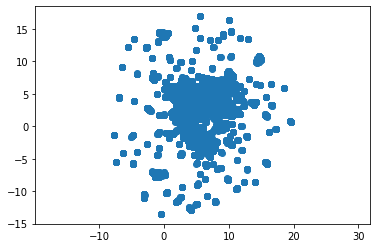

In [23]:
#quick plot to take a look
plt.scatter(
    embedding[:, 0],
    embedding[:, 1])
    
plt.gca().set_aspect('equal', 'datalim')

In [24]:
embedding_df = pd.DataFrame(embedding)
embedding_df['gene_symbol'] = proteins_df['gene_symbol']
embedding_df = embedding_df.rename(columns={1: 'UMAP 1', 0: 'UMAP 0'})
embedding_df.head()

,UMAP 0,UMAP 1,gene_symbol
0,5.097814,-5.611403,A1BG
1,7.777189,1.527883,A1CF
2,4.408378,-1.115858,A2M
3,4.406323,-1.111777,A2ML1
4,3.343802,-1.528773,A3GALT2


In [25]:
#reorder columns
cols = embedding_df.columns.tolist()
cols = cols[-1:] + cols[:-1]
embedding_df = embedding_df[cols]

In [26]:
embedding_df.to_csv(os.path.join(embedding_file_path_processed, "gene_symbol_summarized_UMAP_t5_xl_u50.csv"))